In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device="cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# the Fourier Feature Mapping Layer
class FourierFeatureMapping(nn.Module):
    def __init__(self, in_features, mapping_size, scale=1.0):
        super().__init__()
        # B matrix for mapping (random frequencies)
        self.B = nn.Parameter(torch.randn(mapping_size, in_features) * scale, requires_grad=False)

    def forward(self, x):
        # x shape: (batch_size, in_features)
        x_proj = (2.0 * torch.pi * x) @ self.B.T
        # Concatenate sin and cos features
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


In [3]:
# the Physics-Informed Neural Network
class PhysicsInformedNN(nn.Module):
    def __init__(self, in_nodes=1, mapping_size=10, hidden_nodes=20):
        super().__init__()
        # Fourier Mapping layer
        self.fourier_map = FourierFeatureMapping(in_nodes, mapping_size, scale=1.0)
        
        # The input to fc1 is 2 * mapping_size because of sin and cos concatenation
        self.fc1 = nn.Linear(mapping_size * 2, hidden_nodes)
        self.fc2 = nn.Linear(hidden_nodes, hidden_nodes)
        self.fc3 = nn.Linear(hidden_nodes, 1)

    def forward(self, x):
        x = self.fourier_map(x)
        x = F.relu6(self.fc1(x))
        x = F.relu6(self.fc2(x))
        x = self.fc3(x)
        return x

    def physics_loss(self, x):
        # We need gradients with respect to the input x
        x.requires_grad_(True)
        u = self.forward(x)
        
        # Compute first derivative (u_x)
        u_x = torch.autograd.grad(
            outputs=u, inputs=x, 
            grad_outputs=torch.ones_like(u), 
            create_graph=True
        )[0]
        
        # Compute second derivative (u_xx)
        u_xx = torch.autograd.grad(
            outputs=u_x, inputs=x, 
            grad_outputs=torch.ones_like(u_x), 
            create_graph=True
        )[0]
        
        # Physics for y = sin(x) is the harmonic oscillator: u_xx + u = 0
        residual = u_xx + u
        return F.mse_loss(residual, torch.zeros_like(residual))

    def parseval_theorem_loss(self, x, y):
        u = self.forward(x)
        # PyTorch's native FFT so gradients are preserved
        # norm="ortho" automatically preserves energy scaling between domains
        U_freq = torch.fft.fft(u.squeeze(), norm="ortho")
        Y_freq = torch.fft.fft(y.squeeze(), norm="ortho")
        # Parseval's loss: compare the magnitude spectrums (energy)
        return F.mse_loss(torch.abs(U_freq), torch.abs(Y_freq))

    def total_loss(self, x, y):
        data_loss = F.mse_loss(self.forward(x), y)
        phys_loss = self.physics_loss(x)
        freq_loss = self.parseval_theorem_loss(x, y)
        return data_loss + phys_loss + freq_loss


In [4]:
# Training Loop Setup
model = PhysicsInformedNN(in_nodes=1, mapping_size=13, hidden_nodes=40).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Generate training data: y = sin(x)
x_train = torch.linspace(0, 10, 100).unsqueeze(1).to(device)  # shape (100, 1)
y_train = torch.cos(x_train).to(device)                       # shape (100, 1)
loss_history = []
print("Starting training...")
for epoch in range(1201):
    optimizer.zero_grad()
    
    # Calculate loss and backpropagate
    loss = model.total_loss(x_train, y_train)
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch:4d} | Total Loss: {loss.item():.6f}')
        

Starting training...


C:\Users\devan\AppData\Roaming\Python\Python311\site-packages\torch\autograd\graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch    0 | Total Loss: 7.916937
Epoch  100 | Total Loss: 0.380538
Epoch  200 | Total Loss: 0.216772
Epoch  300 | Total Loss: 0.127616
Epoch  400 | Total Loss: 0.052533
Epoch  500 | Total Loss: 0.003603
Epoch  600 | Total Loss: 0.001911
Epoch  700 | Total Loss: 0.001089
Epoch  800 | Total Loss: 0.000648
Epoch  900 | Total Loss: 0.000603
Epoch 1000 | Total Loss: 0.000300
Epoch 1100 | Total Loss: 0.001134
Epoch 1200 | Total Loss: 0.000447


In [12]:
from torchviz import make_dot
import torch
x_dummy = torch.randn(1, 1).to(device)
y_pred = model(x_dummy)
graph = make_dot(y_pred, params=dict(model.named_parameters()))
graph.render("wave_eq_model_graph", format="png")

'wave_eq_model_graph.png'

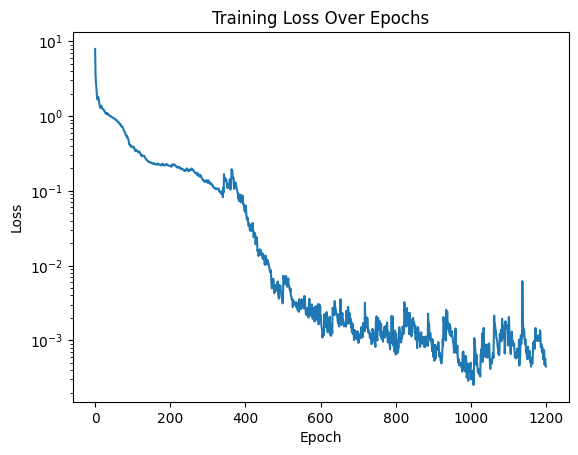

In [6]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

Training complete. Generating plot...


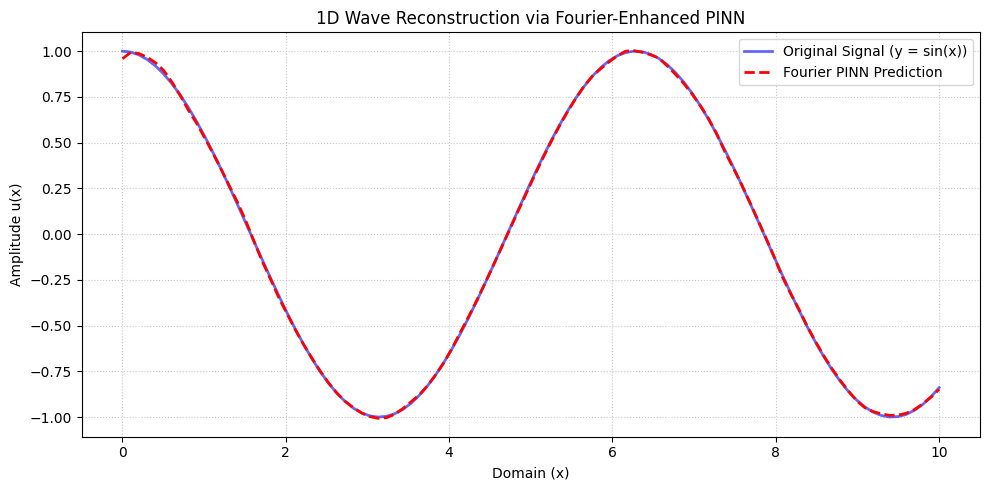

In [7]:
print("Training complete. Generating plot...")

model.eval()

# Generate predictions without tracking gradients
with torch.no_grad():
    y_pred = model(x_train).cpu().numpy()
    y_true = y_train.cpu().numpy()
    x_np = x_train.cpu().numpy()


plt.figure(figsize=(10, 5))
plt.plot(x_np, y_true, label="Original Signal (y = sin(x))", color="blue", linewidth=2, alpha=0.6)
plt.plot(x_np, y_pred, label="Fourier PINN Prediction", color="red", linestyle="--", linewidth=2)

plt.title("1D Wave Reconstruction via Fourier-Enhanced PINN")
plt.xlabel("Domain (x)")
plt.ylabel("Amplitude u(x)")
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
from scipy.io import wavfile
import numpy as np

print("Generating audible prediction file...")

# We need a standard audio sample rate
sample_rate = 8000
duration = 4.0 
current_device = next(model.parameters()).device 

# Create the tensor and move it to that device
x_audio = torch.linspace(0, 1000, int(sample_rate * duration)).unsqueeze(1).to(current_device)

# 3. Generate the predictions
model.eval()
with torch.no_grad():
    y_audio_pred = model(x_audio).cpu().numpy().flatten()

# 4. Normalize the audio
y_audio_pred = y_audio_pred / np.max(np.abs(y_audio_pred))
y_audio_pred = np.float32(y_audio_pred)

# 5. Save it to a file
output_path = "2_prediction.wav"
wavfile.write(output_path, sample_rate, y_audio_pred)

print(f" Success! Audio saved to: {output_path}")

Generating audible prediction file...
 Success! Audio saved to: 2_prediction.wav
